# Turing Target Practice

## Model

In [14]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using PyPlot

using Revise
using MCHMC

In [15]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [16]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [17]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.25)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [18]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [19]:
target = TuringTarget(stat_model);

In [20]:
eps=0.005
L=sqrt(2)
mchmc = Sampler(eps=eps, L=L, integrator="MN")

Sampler(Settings(Random.MersenneTwister(0), 0.005, 1.4142135623730951, 0.0, 0.1931833275037836, 0.0005, 2000, 1000, 10, "MN"), MCHMC.Minimal_norm)

In [33]:
samples_mchmc = Sample(mchmc, target; num_steps=30000);

LoadError: MethodError: no method matching (::MCHMC.var"#prior_draw#74"{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :σ8), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ8, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:σ8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}})(::Random.MersenneTwister)

In [34]:
samples_mchmc = samples_mchmc[2000:end]

16003-element Vector{Vector{Float64}}:
 [0.22320351063967764, 0.8851882659537313]
 [0.22314207704781516, 0.8844292391678037]
 [0.22308152031433845, 0.8833102939206646]
 [0.2230225509113325, 0.8817401660216548]
 [0.2229640139532716, 0.880073047559934]
 [0.22290857212756007, 0.8778250852953694]
 [0.22285589944481898, 0.8751823311042338]
 [0.22280557358946915, 0.8722594954500302]
 [0.2227541511754833, 0.8694655299351163]
 [0.22270655195447148, 0.8662627861994521]
 [0.2226595212938092, 0.8630074047544318]
 [0.22261311729633676, 0.8596955395828079]
 [0.22256681526205047, 0.8563760087518778]
 ⋮
 [0.21430106346202168, 0.9226432794684299]
 [0.2142603881271266, 0.9256529251974868]
 [0.21421736891726417, 0.9283172730495619]
 [0.21416957604292097, 0.9299948274338025]
 [0.2141189809341566, 0.9301641906468059]
 [0.2140688808873744, 0.9295241404173724]
 [0.21402120395432933, 0.9278994206310666]
 [0.2139764623280995, 0.9256116952386485]
 [0.21393524041360673, 0.9227545781653511]
 [0.213898297272599, 

## Plotting

In [35]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

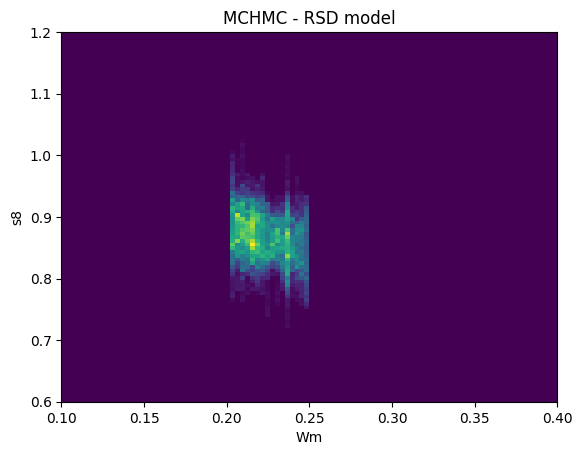

In [36]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

## NUTS

In [37]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling:   1%|▋                                        |  ETA: 0:00:16┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be reje

Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 7.78 seconds
Compute duration  = 7.78 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2243    0.0143     0.0001    0.0002   7466.9002    0.9999    ⋯
          σ8    0.8662    0.0390     0.0004    0.0004   7926.0640    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [38]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

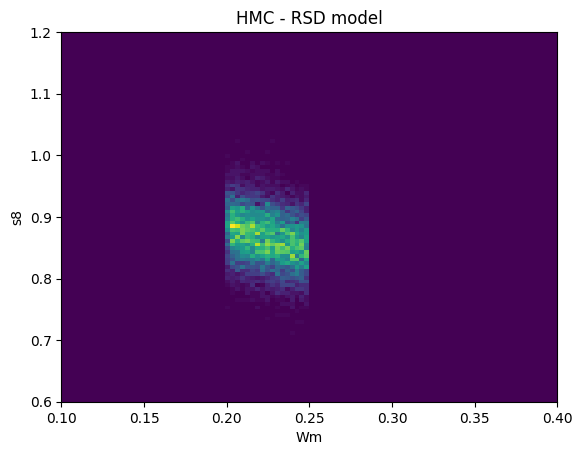

In [39]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");

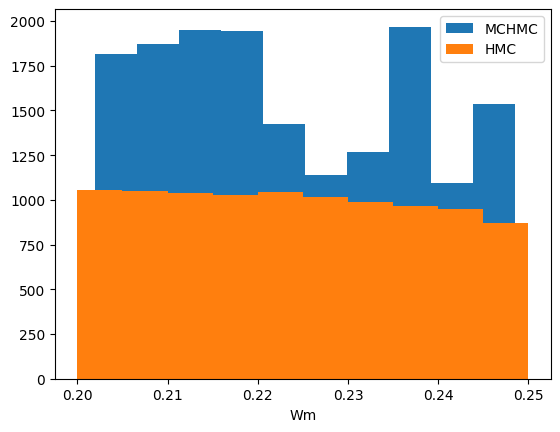

PyObject <matplotlib.legend.Legend object at 0x7fdb7774f7f0>

In [40]:
plt.hist(Wms_mchmc, label="MCHMC")
plt.hist(Wms_hmc, label="HMC")
plt.xlabel("Wm")
plt.legend()

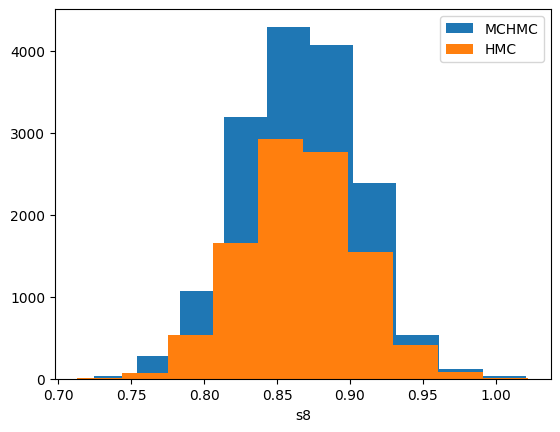

PyObject <matplotlib.legend.Legend object at 0x7fdb779b1a30>

In [41]:
plt.hist(s8s_mchmc, label="MCHMC")
plt.hist(s8s_hmc, label="HMC")
plt.xlabel("s8")
plt.legend()

In [1]:
using AverageShiftedHistograms, Plots

[ Info: Precompiling AverageShiftedHistograms [77b51b56-6f8f-5c3a-9cb4-d71f9594ea6e]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: Module JSON with build ID fafbfcfd-32c8-0809-0000-01243cfb64fa is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1700
[ Info: Skipping precompilation since __precompile__(false). Importing Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80].
┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/QZRtR/src/backends.jl:43


In [43]:
Wm_hmc_ker = ash(Wms_hmc; m=30)
s8_hmc_ker = ash(s8s_hmc; m=30)
Wm_mchmc_ker = ash(Wms_mchmc; m=30)
s8_mchmc_ker = ash(s8s_mchmc; m=30);

In [44]:
Plots.plot(Wm_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(Wm_hmc_ker; hist=false, label="HMC", xlabel="Wm")

LoadError: UndefVarError: `Plots` not defined

In [45]:
Plots.plot(s8_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(s8_hmc_ker; hist=false, label="HMC",  xlabel="s8")

LoadError: UndefVarError: `Plots` not defined

## Self-tuning

In [22]:
mchmc = Sampler()
println(string("L = ", mchmc.settings.L, ", eps = ", mchmc.settings.eps))
# This should start self-tuning    

L = 0.0, eps = 0.0


In [23]:
mchmc.settings.tune_samples

1000

In [24]:
samples = Sample(mchmc, target; num_steps=10000, dialog=true);

Self-tuning hyperparameters
Hyperparameter tuning (first stage)


LoadError: UndefVarError: `samples` not defined